# Setup

In [2]:
# main.py
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import globals as  gl
import factory
import pandas as pd

'''Validating data and create plots'''

gl.init()
# factory.Filter.remove_movement_tutorials()
# factory.Filter.remove_shield_tutorial()

dataframes = gl.dataframes
conc_dataframes = gl.conc_dataframes
conc_dataframes.reset_index(inplace=True)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Barplot: Playing time per user and round

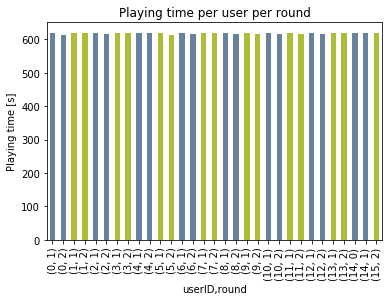

In [3]:
'''Plot: Playing time per user 
'''
plt.ylabel('Playing time [s]')
plt.title('Playing time per user per round')

time_df = conc_dataframes.groupby(['userID', 'round'])['Time'].max()
time_df.plot.bar(color=factory.get_colors())
#plt.savefig(gl.svn_base_path + '/Plots/playing_time_per_user.pdf')

- Lengths are more or less the same, with 613s being the shortest, 766s being the longest

# Plot: Average HR over all games

In [ ]:
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

'''Plot: Average Heartrate 
'''

fig, ax = plt.subplots()
plt.ylabel('Heartrate [bpm]')
plt.xlabel('Playing time [s]')
plt.title('Average Heartrate across all users')

resolution = 10 # resample every x seconds -> the bigger, the smoother

time_df = conc_dataframes.groupby(['userID', 'round'])['Time'].max()
min_time = time_df.min()
conc_with_hr = gl.conc_dataframes_with_hr[gl.conc_dataframes_with_hr['Time']<min_time] # Cut all dataframes to the same minimal length
df_copy = conc_with_hr.copy() # to prevent SettingWithCopyWarning
avg_hr_df = df_copy.groupby(['timedelta'])[['Time','Heartrate']].mean() # Take mean over all logfiles
avg_hr_df_resampled = avg_hr_df.resample(str(resolution)+'S').mean() # Resample series

plt.plot(avg_hr_df_resampled['Time'], avg_hr_df_resampled['Heartrate'])
#plt.savefig(gl.svn_base_path + '/Plots/average_heartrate.pdf')

# Boxplot: Mean and std HR 

In [ ]:
'''Plot: Mean and std bpm per user in a box-chart
'''

df2 = conc_dataframes.pivot(columns=conc_dataframes.columns[1], index=conc_dataframes.index)
df2.columns = df2.columns.droplevel()
conc_dataframes[['Heartrate','userID']].boxplot(by='userID', grid=False, sym='r+')
plt.ylabel('Heartrate [bpm]')
plt.title('')
plt.savefig(gl.svn_base_path + '/Plots/mean_heartrate_boxplot.pdf')

# Barplot: Heartrate Change

In [ ]:
''' Plot Heartrate change
'''
bpm_changes_max = []  # Stores max. absolute change in HR per logfile 
bpm_changes_rel = [] # Stores max. percentage change in HR per logfile 


X = []
for idx, df in enumerate(dataframes):
    if not (df['Heartrate'] == -1).all():
        X.append(idx)
        #new = df.set_index('timedelta', inplace=False)
        resampled = factory.resample_dataframe(df, 1)
        percentage_change = np.diff(resampled['Heartrate']) / resampled['Heartrate'][:-1] * 100.
        x = percentage_change[np.logical_not(np.isnan(percentage_change))]
        bpm_changes_max.append(x.max())
        bpm_changes_rel.append(x)
#plt.ylabel('#Times HR changed')
#plt.xlabel('Change in Heartrate [%]')
#for idx, l in enumerate(bpm_changes_rel):
    #plt.figure()
    #print(l)
    #plt.title('Heartrate change for plot' + str(idx))
    #plt.hist(l, color=gl.green_color)
    #plt.savefig(gl.svn_base_path + '/Plots/Heartrate Histograms/heartrate_change_percentage' + str(idx) + '.pdf')


plt.figure()
plt.title('Maximal heartrate change')
plt.ylabel('Max heartrate change [%]')
plt.xlabel('Logfile')
plt.bar([x for x in X], bpm_changes_max, color=gl.blue_color, width=0.25)
#plt.savefig(gl.svn_base_path + '/Plots/heartrate_change_abs.pdf')

- Most of the logfiles don't have unusual behavior uf the HR, menaing a maximal change of <20% between consecutive measurements 

# Plot: Heartrate correlated with Difficulty

In [ ]:
factory.plot_difficulty_corr_with('Heartrate')

- Not a lot of difficulty changes unfortunately
- A small correlation

# Plot: Points correlated with Difficulty

In [ ]:
factory.plot_difficulty_corr_with('Points')

# Scatter plot: Difficulty vs. size of obstacles 

In [ ]:
plt.figure()
values = factory.get_number_of_obstacles_per_difficulty()
print(values)
for i in [0,1,2]:
    li = values[5*i:5*i+5]
    maximum = max(li) if (max(li) >0) else 1
    values[5*i:5*i+5] = [x / maximum * 2000 for x in li] 
plt.title('Difficulty vs. size of obstacles')
plt.ylabel('#occurences for given size')
plt.xlabel('Difficulty')
x = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
y = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]
plt.scatter(x, y, s=values)
plt.savefig(gl.svn_base_path + '/Plots/corr_difficulty_numObstacles.pdf')

Difficulty level corresponds mostly to bigger obstacles

# Obstacle Information

In [ ]:
# Idea: Get % of crashes per difficulty level
df = conc_dataframes

grouped2 = df.groupby(['physDifficulty', 'Logtype']).size()
print(grouped2)

print('\nOn physDifficulty=HIGH, there were ' + str(grouped2[2]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[1]) + \
      ', i.e. ' + str(round(grouped2[1]/grouped2[2],2)*100) + '%.' )

print('On physDifficulty=MEDIUM, there were ' + str(grouped2[6]) + \
      ' obstacles, out of which the user crashed ' + str(grouped2[5]) + \
      ', i.e. ' + str(round(grouped2[5]/grouped2[6],2)*100) + '%.' )


#  Scatter plot: Difficulty vs HR

In [ ]:
df = gl.conc_dataframes_with_hr
df_num = factory.transformToNumbers(df)
df_num.set_index('timedelta', inplace=True)
resolution=5
# resample and take mean over difficulty. This means that a point can now have a difficulty "between"
# Low/Medium/High, depending on how many seconds out of the resolution seconds it was on which level.
avg_hr_df_resampled = df_num.resample(str(resolution)+'S').mean() 

plt.title('Difficulty vs. HR')
plt.ylabel('HR')
plt.xlabel('Difficulty')
x = avg_hr_df_resampled['physDifficulty']
y = avg_hr_df_resampled['Heartrate']
plt.scatter(x, y, s=30)
#plt.savefig(gl.svn_base_path + '/Plots/corr_difficulty_HR.pdf')

- Difficulty indeed has an influence on Heartrate


# Barplot:  Crashes vs size of obstacle

In [ ]:
conc_num = factory.transformToNumbers(conc_dataframes) # Transform Difficulties into integers
new = conc_num['obstacle'].apply(lambda x: 0 if x=='none' else x.count(",") + 1 ) # count number of obstacle parts per obstacle
conc_num = conc_num.assign(numObstacles=new)
# [a,b,c,d,e], e..g  #obstacles that had size 0,1,2,3,4 respectively
num_obstacles_per_size = conc_num.groupby('numObstacles').size().tolist()

num_obstacles_per_size.insert(2,0) # No obstacles of size 2...
num_crashes_per_size = [0,0,0,0,0]

#For each crash, find corresponding row where we can find the size of the obstacle he crashed into.
for index, row in conc_num.iterrows():
    if (row['Logtype']=='EVENT_CRASH'):
        next_obstacle_idx = factory.get_next_obstacle_idx(index, conc_num)
        sizeOfObstacle = conc_num.iloc[next_obstacle_idx]['numObstacles']
        num_crashes_per_size[sizeOfObstacle] +=1       
percentage_of_crashes = [0 if (x==0 | y==0) else x/y for x, y in zip(num_crashes_per_size, num_obstacles_per_size)]     

x = [0,1,2,3,4]
plt.title('Crashes vs. size of obstacle')
plt.ylabel('Crashes [%]')
plt.xlabel('Size of obstacle')
plt.bar(x, percentage_of_crashes)

#plt.savefig(gl.svn_base_path + '/Plots/crashes_per_size_of_obstacles.pdf')

- Bigger obstacle doesn't really mean that the chance for the user to crash is bigger!

# %Crashes in the last 30 seconds

In [ ]:
window = 80 #Over how many seconds should we caluculate %crashes?
resolution = 15 #Resampling interval

def df_from_to(_from, _to):
    mask = (_from<df['Time']) & (df['Time']<=_to)
    return df[mask]
    
def computeCrashes(row):
    last_x_seconds_df = df_from_to(max(0,row['Time']-window), row['Time'])
    num_obstacles = len(last_x_seconds_df[last_x_seconds_df['Logtype']=='EVENT_OBSTACLE'].index)
    num_crashes = len(last_x_seconds_df[last_x_seconds_df['Logtype']=='EVENT_CRASH'].index)
    return (num_crashes/num_obstacles *100 if num_crashes<num_obstacles else 100) if num_obstacles!=0 else 0


for idx, df in enumerate(gl.dataframes):
        if not (df['Heartrate'] == -1).all():
                # Plot Heartrate
                fig, ax1 = plt.subplots()
                fig.suptitle('% of crashes in the last x seconds')
                df_num_resampled = factory.resample_dataframe(df, resolution)

                ax1.plot(df_num_resampled['Time'], df_num_resampled['Heartrate'], gl.blue_color)
                ax1.set_xlabel('Playing time')
                ax1.set_ylabel('Heartrate', color=gl.blue_color)
                ax1.tick_params('y', colors=gl.blue_color)

                #Plot %crashes
                ax2 = ax1.twinx()
                df['%crashes'] = df[['Time', 'Logtype']].apply(computeCrashes,axis=1)
                resampled = factory.resample_dataframe(df, resolution)
                ax2.plot(resampled['Time'], resampled['%crashes'], gl.green_color)
                ax2.set_ylabel('Crashes [%]', color=gl.green_color)
                ax2.set_xlabel('Time')
                ax2.tick_params('y', colors=gl.green_color)

                plt.savefig(gl.svn_base_path + '/Plots/%Crashes/%crashes_heartrate_' +gl.rel_files[idx] + '.pdf')


# Crashes per obstacle arrangement

In [ ]:
import collections

conc_num = factory.transformToNumbers(conc_dataframes) # Transform Difficulties into integers

#For each obstacle-arrangment, make a dictionary-entry with a list [#occurences, #crashes]
obst_dict = {}
#For each crash, find corresponding row where we can find the obstacle he crashed into.
for index, row in conc_num.iterrows():
    if (row['Logtype']=='EVENT_CRASH'):
        next_obstacle_idx = factory.get_next_obstacle_idx(index, conc_num)
        obstacle = conc_num.iloc[next_obstacle_idx]['obstacle']
        #print(conc_num.iloc[next_obstacle_idx]['timedelta'] - row['timedelta'])
        if obstacle in obst_dict:
            obst_dict[obstacle] = [obst_dict[obstacle][0] +1, obst_dict[obstacle][1]+1]
        else:    
            obst_dict[obstacle] = [1,1]
    if (row['Logtype']=='EVENT_OBSTACLE'):
        obstacle = row['obstacle']
        if obstacle in obst_dict:
            obst_dict[obstacle] = [obst_dict[obstacle][0] +1, obst_dict[obstacle][1]]
        else:    
            obst_dict[obstacle] = [1,0]

obst_dict = collections.OrderedDict(sorted(obst_dict.items(),key=lambda s: len(s[0])))
index = obst_dict.keys()
columns=["#Occurences", "#Crashes", "Crashes in %"]
data = np.zeros(shape=(len(index),3))
count=0
for key, value in obst_dict.items():
    data[count][0] = value[0] # #Occurences
    data[count][1] = value[1] # #Crashes
    data[count][2] = value[1]/value[0] *100
    count+=1

df = pd.DataFrame(data, index=index, columns=columns)
plt.xticks(rotation=90)
plt.title('Crashes vs. size of obstacle')
plt.ylabel('Crashes [%]')
plt.xlabel('Size of obstacle')
plt.bar(df.index, df['Crashes in %'])


plt.savefig(gl.svn_base_path + '/Plots/crashes_per_obstacle_arrangement.pdf',bbox_inches="tight")